In [1]:
%run init_notebookspace.py
from settings import DATA_DIR, MODEL_DIR, POST_EST_DIR

DATA_DIR is existant under: C:\Users\LukasGrahl\Documents\GIT\memoire1\data


In [2]:
from config import mod4_params, fred_dict, recession_dict

In [3]:
%matplotlib inline

from gEconpy.classes.model import gEconModel
from gEconpy.classes.transformers import IntervalTransformer
from gEconpy import compile_to_statsmodels
from gEconpy.plotting import plotting as gp


import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import xarray as xr
import pandas as pd

import os
import time


from src.plotting import plot_dfs
from src.gp_plotting import plot_sm_results
from src.process_data import load_data
from src.filtering import kalman_predict, kalman_update, kalman_filter

from config import plt_config
plt.rcParams.update(plt_config)

load data

In [4]:
from config import fred_dict

df = load_data('prepro_data.csv', DATA_DIR, fred_dict)

# using real potential GDP instead of GDP
df = df.drop(['pi_c', 'Ix', 'Zx', 'Y', 'pi_s', 'w'], axis=1).rename(columns={'Y_p': 'Y'})

train = df[df['is_test'] == False].drop('is_test', axis=1).copy()
test = df[df['is_test'] == True].drop('is_test', axis=1).copy()

Error occured 'is_test', file_dict may be incomplete


load & solve model

In [5]:
mod = gEconModel(os.path.join(MODEL_DIR, 'gEconpy_mod4_rbc_complete.gcn'), verbose=True)

Model Building Complete.
Found:
	9 equations
	9 variables
	The following variables were eliminated at user request:
		TC_t,U_t
	The following "variables" were defined as constants and have been substituted away:
		mc_t
	1 stochastic shock
		 1 / 1 have a defined prior. 
	6 parameters
		 4 / 6 has a defined prior. 
	0 calibrating equations
	0 parameters to calibrate
 Model appears well defined and ready to proceed to solving.



In [6]:
# assign parameters
mod.free_param_dict.update(mod4_params)

In [7]:
mod.steady_state()
mod.solve_model()
mod.check_bk_condition();

Steady state found! Sum of squared residuals is 6.695239551090784e-23
Solution found, sum of squared residuals:  8.256002816550977e-31
Norm of deterministic part: 0.000000000
Norm of stochastic part:    0.000000000
Model solution has 2 eigenvalues greater than one in modulus and 2 forward-looking variables.
Blanchard-Kahn condition is satisfied.


## Kalman Filter Estimation

In [8]:
# from gEconpy.estimation.estimate import build_Q_and_H
# from gEconpy.estimation.estimation_utilities import split_random_variables
# # from gEconpy.estimation.estimate import build_Z_matrix
# # from gEconpy.estimation.kalman_filter import kalman_filter
# from scipy import linalg

In [9]:
from scipy.stats import gamma, beta
prior_dist = {
    # 'alpha': beta(1.4, 10),
    'beta': beta(.9, 1.5),
    'sigma_C': gamma(a=3.9, loc=0, scale=0.757575757575758),
    'sigma_L': gamma(a=1.9, loc=0, scale=2.63157894736842),
    # 'eta_p': beta(2.4, 1.2),
    # 'eta_w': beta(2.4, 1.2),
    # 'phi_H': beta(1.2, 1.2),
    'epsilon_test': beta(1.2, 1.2),
    'epsilon_A': beta(1.2, 1.2)
            }

test_params = mod4_params.copy()
test_params.update(epsilon_test=.44)

In [10]:
def sample_from_priors(priors: dict, mod_params: dict, shock_names) -> (dict, dict, dict):
    params = {k: v for k, v in zip(priors.keys(), [item.rvs() for item in priors.values()]) if k not in shock_names}
    shocks = {k: v for k, v in zip(priors.keys(), [item.rvs() for item in priors.values()]) if k in shock_names}
    return params, shocks

def get_Q_H(shocks_dict, observed_names, noise_diag):
    Q = np.diag([v for v in shocks_dict.values()])
    assert len(noise_diag) == len(observed_names), f"H matrix needs zdim x zdim, but is {len(noise_diag)} x {len(noise_diag)}"
    H = np.diag(noise_diag)
    return Q, H

In [11]:
state_vars = [x.base_name for x in mod.variables]
observed_vars = ['Y', 'C']
shock_names = [x.base_name for x in mod.shocks]

xdim = len(state_vars)
zdim = len(observed_vars)
print(f'Filter has x: {xdim} and z: {zdim}')

# param_dicts = pd.DataFrame(mod.sample_param_dict_from_prior(1, sample_shock_sigma=True)).T.to_dict()
# param_dict = param_dicts[0]
# param_dict, shock_dict, obs_dict = split_random_variables(param_dict, shock_names, observed_vars)

# set(param_dict.keys()).symmetric_difference(set(mod.free_param_dict.keys()))
# Q, H = build_Q_and_H(shock_dict, shock_names, observed_vars, dict(zip(observed_vars, [1e-08, 1e-08])))

params, shocks = sample_from_priors(prior_dist, mod4_params, shock_names)
Q, H = get_Q_H(shocks, observed_vars, [1e-8, 1e-8])

Z = np.array([[x == var for x in state_vars] for var in observed_vars], dtype='float64')

T, R = mod.T.values, mod.R.values

QN = R @ Q @ R.T
from sklearn.datasets import make_spd_matrix
# QN = make_spd_matrix(xdim)

zs = train[observed_vars].values.copy()

Filter has x: 9 and z: 2


In [12]:
np.all(np.linalg.eigvals(QN) > 0)

False

### filterpy

In [13]:
from filterpy.kalman import KalmanFilter
kfilter = KalmanFilter(xdim, zdim)
kfilter.F = T

kfilter.Q = QN

kfilter.H = Z
kfilter.R = H

In [14]:
mu, cov, _, _ = kfilter.batch_filter(zs)
mu_df = pd.DataFrame(mu.reshape(len(mu), -1), columns=state_vars, index=train.index)

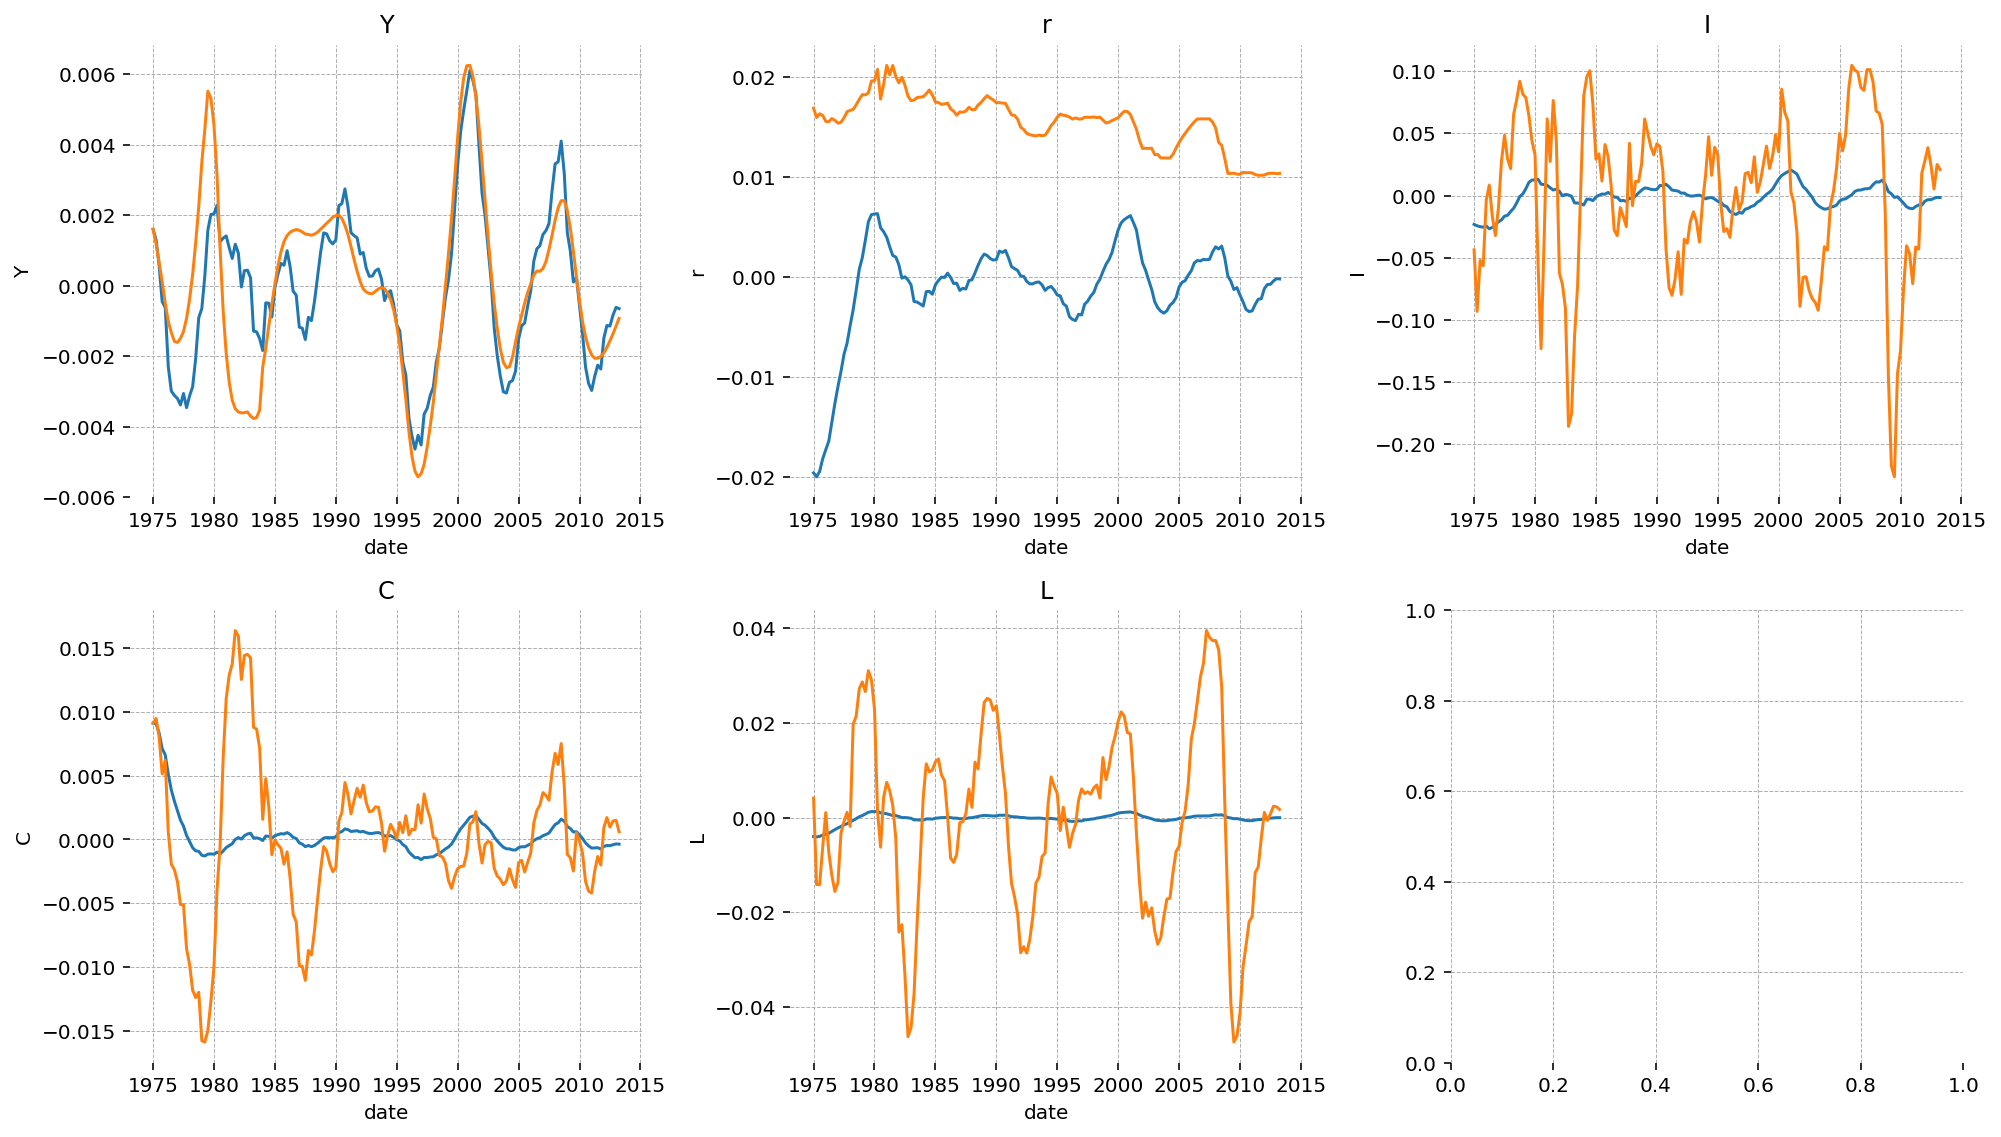

In [15]:
plot_dfs([mu_df[train.columns], train], sns.lineplot)

#### my filter

In [24]:
x = np.zeros(xdim)
P = np.diag([.1]*xdim)

In [25]:
mu, cov, ll = kalman_filter(zs, x, P, T, QN, Z, H)

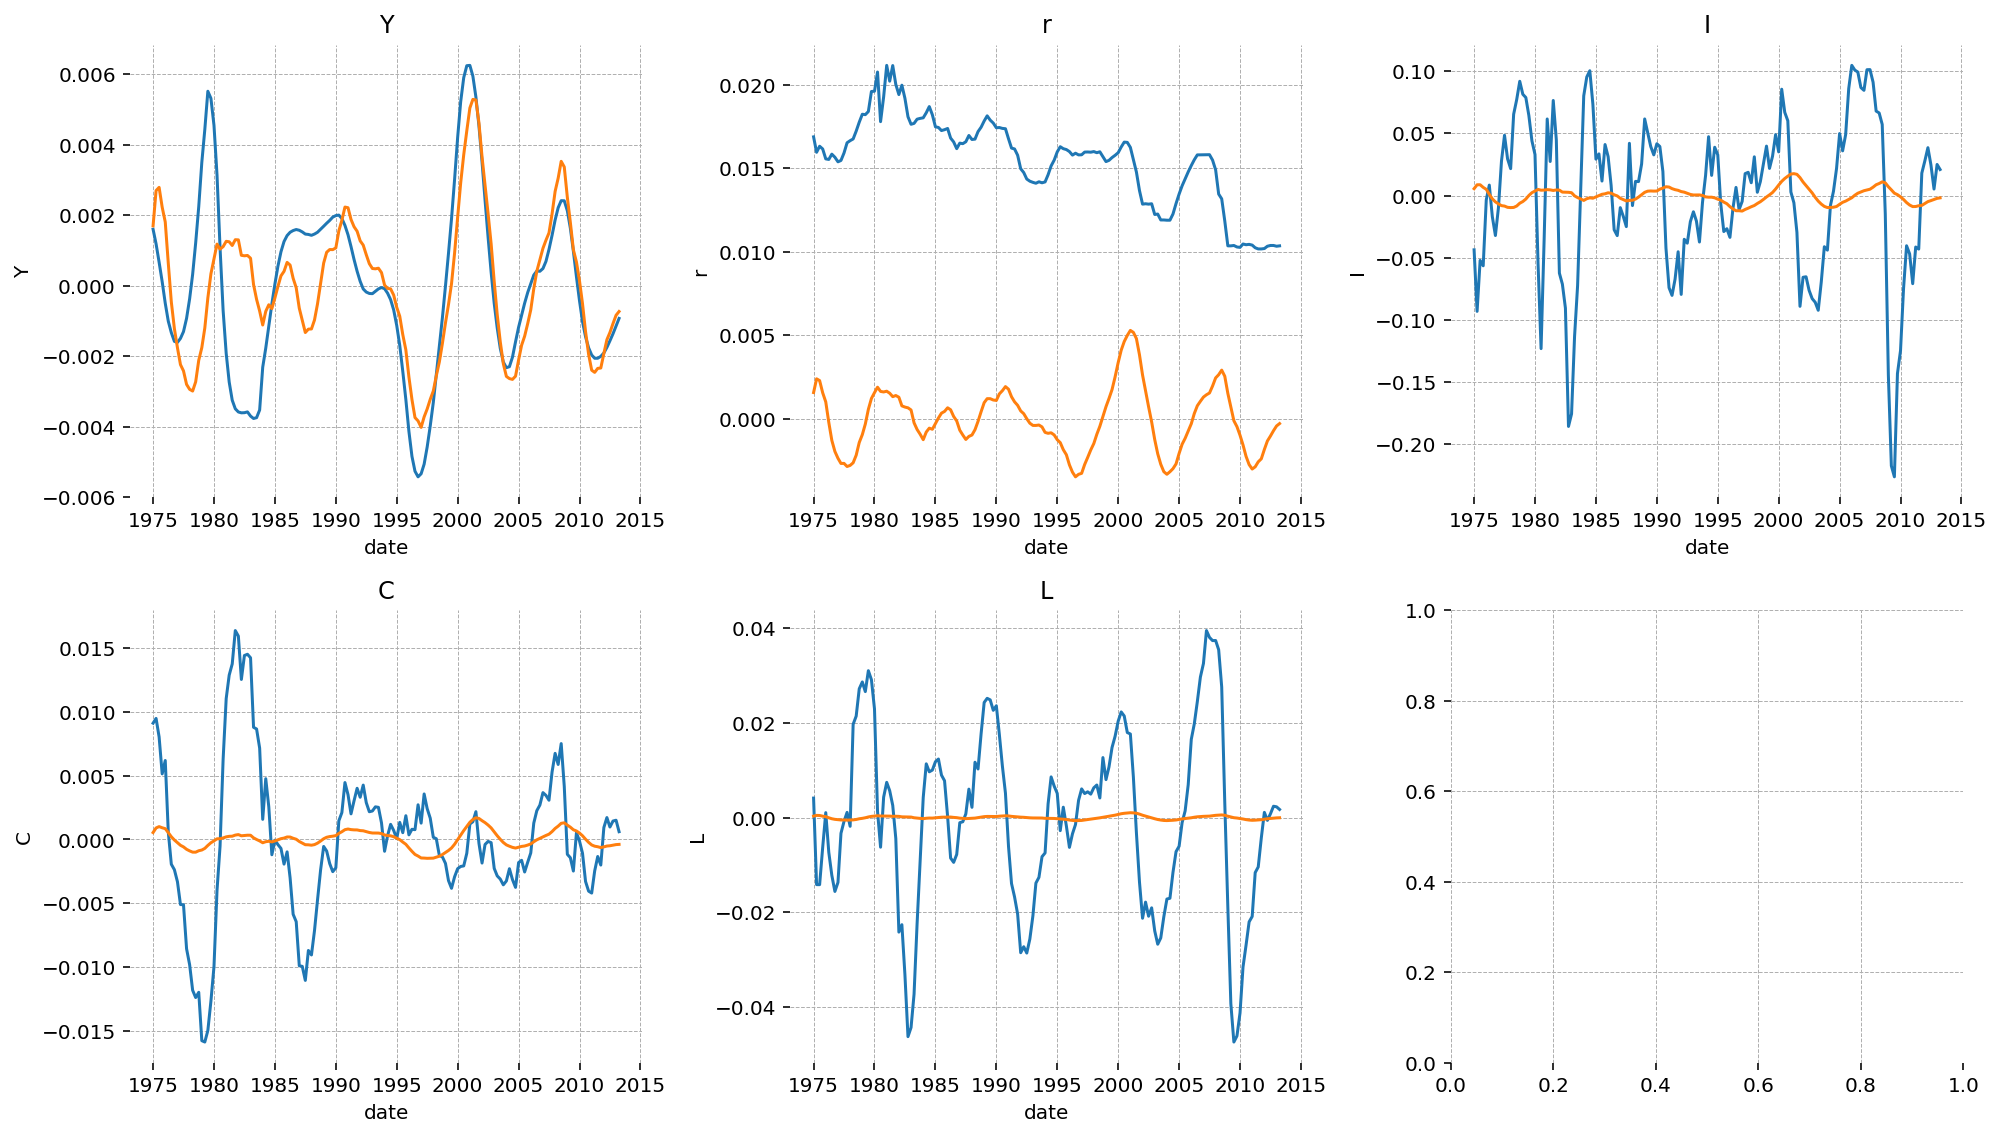

In [28]:
mu_df = pd.DataFrame(mu, index=train.index, columns=state_vars)

plot_dfs([train, mu_df[train.columns]], sns.lineplot)

#### old code

In [9]:
observed = ["Y", "pi_obj"]

filter_vars = list(mod.T.columns)
observed_ind = [filter_vars.index(item) for item in observed]
for i in observed:
    assert (i in filter_vars) == True, f"{i} not in filter_vars"

    
xdim = len(filter_vars)
zdim = len(observed)
print(f'xdim: {xdim} \nzdim: {zdim}')

xdim: 25 
zdim: 2


In [10]:
from filterpy.kalman import KalmanFilter
kfilter = KalmanFilter(dim_x=xdim, dim_z=zdim)

kfilter.F = mod.T.loc[filter_vars, filter_vars].values

kfilter.R = np.eye(zdim) * 0.01

for i, ind in enumerate(observed_ind):
    kfilter.H[i, ind] = 1

In [11]:
zs = train[observed].values

In [12]:
# kfilter.predict()
# kfilter.update(zs[0])
# kfilter.log_likelihood_of(zs[0])

In [13]:
mu, cov, _, _ = kfilter.batch_filter(zs)

In [14]:
mu_df = pd.DataFrame(mu.reshape(len(mu), -1), columns=filter_vars)
mask_f = mu_df[[item for item in train.columns if item in mu_df.columns]].copy()
mask_t = train[list(mask_f.columns)].reset_index(drop=True).copy()

plot_dfs([mask_t, mask_f], sns.lineplot)

''

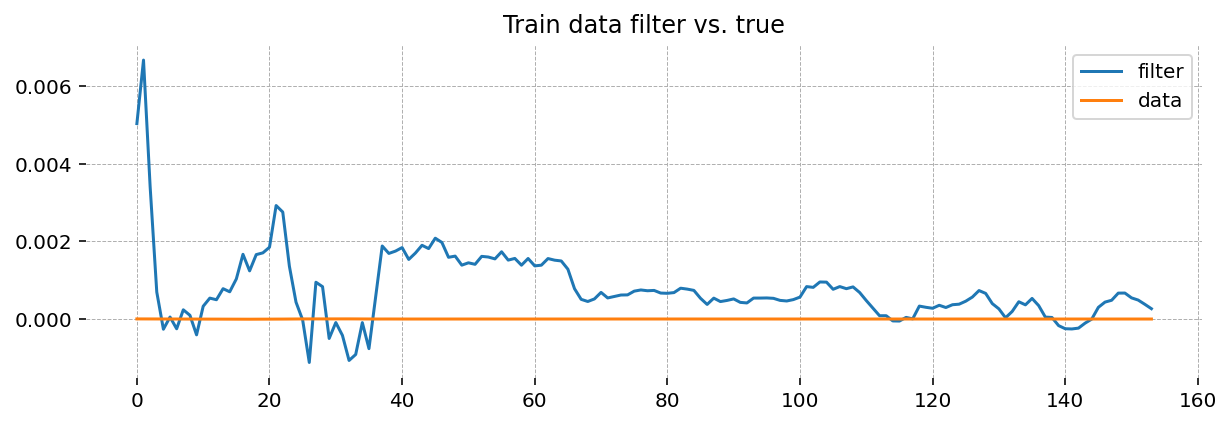

In [16]:
var = "C"
plt.plot(mu[:, filter_vars.index(var)].reshape(-1))
try:
    plt.plot(train[var].values)
except KeyError:
        _ = False
plt.title("Train data filter vs. true")
plt.legend(['filter', 'data'])
;

## drawing from priors

In [119]:
from scipy.stats import gamma, norm, beta, uniform
import scipy

In [18]:
def solve_updated_mod(mod, verbose: bool=True):
    
    # solve for steady state
    mod.steady_state(verbose=verbose)
    is_solved = mod.steady_state_solved
    if not is_solved:
        return False, mod
    
    # solve model, capture np.LinAlgEr
    try:
        mod.solve_model(verbose=verbose)
    except np.linalg.LinAlgError:
        return False, mod

    # check blanchard kahn
    is_bk = mod.check_bk_condition(return_value='bool', verbose=verbose)
            
    return is_solved & is_bk, mod

In [19]:
def get_KalmanFilter_obj(observed_vars: list, observed_ind: list,
                         all_vars: list, T: np.array, R_diag: list):
       
    # setting dimensions based on observables and overall system size
    xdim = len(all_vars)
    zdim = len(observed_vars)
    
    assert len(R_diag) == zdim, f"R_diag is of len {len(R_diag)} should be of len (zdim)"
        
    # initialising the Kalman Filter
    kfilter = KalmanFilter(dim_x=xdim, dim_z=zdim)
    kfilter.F = T
    kfilter.R = np.diag(R_diag)
    for i, ind in enumerate(observed_ind):
        kfilter.H[i, ind] = 1
    return kfilter

In [20]:
from filterpy.kalman import KalmanFilter
def get_kalman_log_likelihood(observed_vars: list, all_vars: list,
                              measurements: np.array, T: np.array,
                              R_diag: list, ret_all: bool = False):
    
    # outputs
    log_likelihood = []
    mu, cov = None, None
    
    if ret_all:
        mu, cov = [], []
    
    observed_ind = [all_vars.index(item) for item in observed_vars]
    
    # sanity
    # add measurement == observed sanity
    for i in observed_vars:
        assert (i in all_vars) == True, f"{i} not in filter_vars"
        
    kfilter = get_KalmanFilter_obj(observed_vars, observed_ind, all_vars, mod.T.values, R_diag)
    
    # predict, update, loglike
    for i in measurements:
        kfilter.predict()
        kfilter.update(i)
        
        log_likelihood.append(kfilter.log_likelihood)
        if ret_all:
            mu.append(kfilter.x_post)
            cov.append(kfilter.P_post)
            
    return log_likelihood, mu, cov

In [21]:
def get_arr_pdf_from_dist(dict_vals, dict_dists):
    # Get pdf from distribution for val
    return np.array([dict_dists[item].pdf(dict_vals[item]) for item in dict_vals.keys()])

In [22]:
def printProgBar(iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█', printEnd = "\r"):
    perc = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print(f'\r{prefix} |{bar}| {perc}% {suffix}', end = printEnd)
    # Print New Line on Complete
    if iteration == total: 
        print()
    pass

In [24]:
test, _, _ = get_kalman_log_likelihood(["Y", 'pi_obj'], 
                                       list(mod.T.columns),
                                       train[["Y", "pi_obj"]].values,
                                       T=mod.T.values,
                                       R_diag=[.01, .01],
                                       ret_all=False)

In [25]:
# need for sample from 

prior_dist = {
    # 'alpha': beta(1.4, 10),
    'beta': beta(.9, 1.5),
    'sigma_C': gamma(a=3.9, loc=0, scale=0.757575757575758),
    'sigma_L': gamma(a=1.9, loc=0, scale=2.63157894736842),
    'eta_p': beta(2.4, 1.2),
    'eta_w': beta(2.4, 1.2),
    'phi_H': beta(1.2, 1.2)
            }

In [29]:
start = time.time()

mod_out = {}
n_param_dim_out = []
n_dim_out = []

# define stepsize of MCMC.
stepsizes = [0.005]  # array of stepsizes
counter = 0.0
n_runs = 1000

posterior = {item: [mod7_params[item]] for item in prior_dist.keys()}

# reset params
mod.free_param_dict.update(mod7_params)

for i in range(0, n_runs):
    printProgBar(i, n_runs-1, prefix='Progress')
    
    # old log_likelihood
    old_loglike, _, _ = get_kalman_log_likelihood(["Y", 'pi_obj'], 
                                                   list(mod.T.columns),
                                                   train[["Y", "pi_obj"]].values,
                                                   T=mod.T.values,
                                                   R_diag=[.01, .01],
                                                   ret_all=False)
    old_loglike = sum(old_loglike)

    # draw params from prior & update
    old_prior = {item: vals[-1] for item, vals in posterior.items()}
    new_prior = {k: v for k, v in zip(prior_dist.keys(), [item.rvs() for item in prior_dist.values()])}
    # mod.free_param_dict.update(prior)
    
    # solve model
    is_solved, mod = solve_updated_mod(mod, verbose=False)
    if not is_solved: continue
    
    # new loglikelihood
    new_loglike, _, _ = get_kalman_log_likelihood(["Y", 'pi_obj'], 
                                                   list(mod.T.columns),
                                                   train[["Y", "pi_obj"]].values,
                                                   T=mod.T.values,
                                                   R_diag=[.01, .01],
                                                   ret_all=False)
    new_loglike = sum(new_loglike)
    
    # MH ratio
    ratio = ((new_loglike * get_arr_pdf_from_dist(new_prior, prior_dist)) / (old_loglike * get_arr_pdf_from_dist(old_prior, prior_dist))).mean()
    ω = min([ratio, 1])
    
    random = np.random.uniform(0, 1)
    
    # merge draws prior into posterior 
    if random <= ω:
        is_accepted = True
        counter += 1.
        for key in new_prior.keys():
            posterior[key].append(new_prior[key])
            
    # leave posterior unaltered and restart
    else:
        is_accepted = False
        counter += 0.
    
    
    
    # save output 
    n_param_dim_out.append(
        [
            [posterior[item][-1] for item in posterior.keys()],
            list(new_prior.values()),
            list(get_arr_pdf_from_dist(new_prior, prior_dist))
        ]
    )
    
    n_dim_out.append(
        [
            new_loglike
        ]
    )
    
    # mod_out[i] = dict(
    #     zip(
    #         [
    #             'is_solved',
    #             'is_accpeted_MH',
    #             'params',
    #             'T',
    #             'R',
    #             'loglike'
    #         ],
    #         [
    #             is_solved,
    #             is_accepted,
    #             mod.free_param_dict,
    #             mod.T,
    #             mod.R,
    #             new_loglike
    #         ]
    #     )
    # )
        

print(f"\nAcceptance rate = {round(counter/n_runs, 3)}")
print(f'\nExecution time = {round(time.time() - start, 3)} sec')
n_param_dim_out = np.array(n_param_dim_out)
n_dim_out = np.array(n_dim_out)

Progress |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 

Acceptance rate = 0.947

Execution time = 323.016 sec


In [30]:
# construct xarray

xarr = xr.Dataset(
    {
        'posterior': (['draw', 'parameter'], n_param_dim_out[:, 0]),
        'new_prior': (['draw', 'parameter'], n_param_dim_out[:, 1]),
        'new_prior_pdf': (['draw', 'parameter'], n_param_dim_out[:, 2]),
        'log_like': (['draw'], n_dim_out.reshape(-1))
    },
    coords={
        'draw': (['draw'], list(range(0, n_runs))),
        'parameter': (['parameter'], list(prior_dist.keys()))
    },
)
# xarr

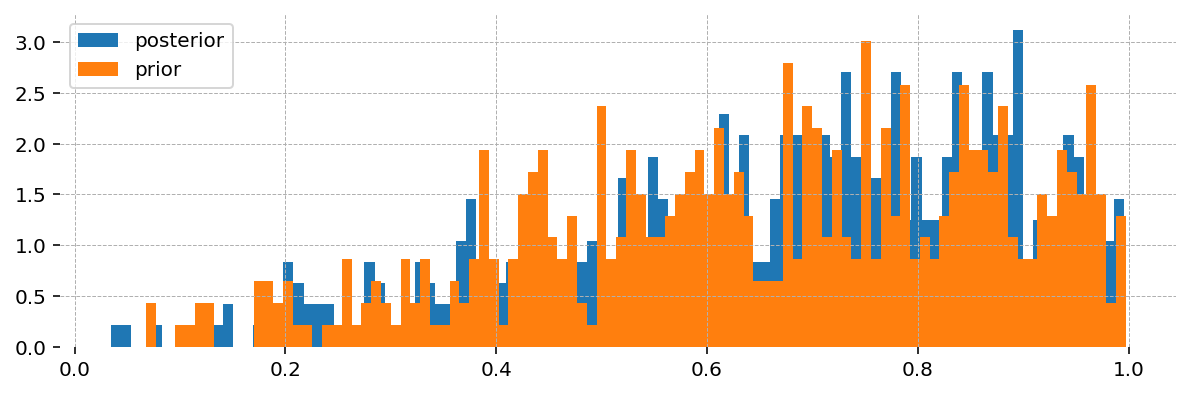

In [31]:
param = 'eta_w'
bins = int(n_runs/10)
plt.hist(xarr.sel(parameter=param).posterior[int(n_runs/2):], bins=bins, density=True);
plt.hist([prior_dist[param].rvs() for item in np.linspace(0, 10, int(n_runs/2))], bins=bins, density=True);
plt.legend(['posterior', 'prior'])

save results 

In [44]:
import pickle
import datetime

suffix = f'{datetime.datetime.now().date()}_{datetime.datetime.now().hour}_{datetime.datetime.now().minute}'

xarr.to_netcdf(os.path.join(DATA_DIR, f"posterior_sym_{suffix}.nc"))

f = open(os.path.join(DATA_DIR, f"mod_sym_{suffix}.pkl"),"wb")
pickle.dump(mod_out,f)
f.close()